In [2]:
# Import data, Define Classes, Subclasses and respective Points
import ee
import geemap
m = geemap.core.Map()
ee.Authenticate()
ee.Initialize()

crudeBorders = ee.Geometry.Polygon(
        [[[-70.07663362002641, 12.642409005331041],
          [-70.08350007510454, 12.528484055387077],
          [-69.95303742862016, 12.419873412682719],
          [-69.85416047549516, 12.389025068780875],
          [-69.84111421084673, 12.40109659488839],
          [-69.86240022158891, 12.486251996961656],
          [-70.05466096377641, 12.641069006200203]]])

classNames = ['Permanent_water', 'Mangrove', 'Herbaceous_wetland', 'Tree_cover', 'Shrubland', 'Sparse', 'Build_environment']
subClassNames = ['Permanent_water', 'Mangrove', 'Dam_tanki', 'Salina', 'Wetland_other', 'Cactus_dominated', 'Deciduous_dominated', 'Shrubland', 
                 'Quarry', 'Degraded_land', 'Sand_coast', 'Rock_coast', 'Rock_formation', 'Dead_mangrove', 'Road', 'Building', 'Sport_field']
problemNames = ['main', 'Herbaceous_wetland', 'Tree_cover', 'Sparse', 'Build_environment']

prettyClassNames = ['Water', 'Mangrove', 'Wetland', 'Tree', 'Shrub', 'Sparse', 'Build']
prettySubClassNames = {'main': prettyClassNames,
                        'Herbaceous_wetland': ['Dam & tanki', 'Salina', 'Other wetland'], 'Tree_cover': ['Cactus', 'Tree'], 
                        'Sparse': ['Quarry', 'Dedgraded', 'Sand coast', 'Rock coast', 'Rock formation', 'Dead mangrove'], 'Build_environment': ['Road', 'Building', 'Sport field'] }
prettyProblemNames = ['Hierarchical classes', 'Main classes', 'Herbaceous wetland', 'Tree cover', 'Sparse', 'Build environment']

classDict = { item: i for i, item in enumerate(classNames)}
subClassDict = { item: i for i, item in enumerate(subClassNames)}
reverse_classDict = {value: key for key, value in classDict.items()}
reverse_subClassDict = {value: key for key, value in subClassDict.items()}
landcoverOffset = {'Herbaceous_wetland': 2, 'Tree_cover': 5, 'Sparse': 8, 'Build_environment': 14}

classesFromSubClasses = {
    'Permanent_water': [0],
    'Mangrove': [1],
    'Herbaceous_wetland': [2,3,4],
    'Tree_cover': [5,6], 
    'Shrubland': [7],
    'Sparse': [8, 9, 10, 11, 12, 13],
    'Build_environment': [14, 15, 16]
}

classPoints = eval(open('./output/classPoints.txt', 'r').read())
subClassPoints = eval(open('./output/subClassPoints.txt', 'r').read())

# ML constants
classPalette = [
  '#0000FF', # Permanent Water: Blue
  '#ff0cf6', # Mangroves: Purple
  '#00FF00', # Herbaceous wetland: Bright Green
  '#008000', # Tree Cover: Dark Green
  '#A52A2A', # Shrubland: Brown
  '#FFFF00', # Bare or sparse vegetation: Yellow
  '#808080', # Built environment: Grey
  '#000000', # No data: Black 
]

classVis = {
  'min': 0,
  'max': 6,
  'palette': classPalette
}

subClassPalette = [
    '0000FF', # Permanent Water: Blue
    'ff0cf6', # Mangroves: Purple
    '99ccff',  # Dam/Tanki: Light Blue
    'cce6ff',  # Salina: Very Light Blue
    '66ff66',  # Wetland_Other: Lighter Bright Green
    'd2b48c',  # Cactus_Dominated: Tan
    '66cc66',  # Deciduous_Dominated: Lighter Dark Green
    'A52A2A', # Shrubland: Brown
    'ffffcc',  # Quarry: Light Yellow
    'cccc00',  # Degraded_Land: Dark Yellow
    'fff5cc',  # Sandcoast: Pale Yellow
    'ffffe6',  # Rockcoast: Greyish Yellow
    'f5f5dc',  # Rockformations: Beige
    'e6cce6',  # Dead Mangrove: Desaturated Purple
    '707070',  # Road: Lighter Dark Grey
    'd9d9d9',  # Building: Light Grey
    'bfbfbf'   # Sportfield: Medium Grey
]

sentinel2Bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']

ml_methods = {'libsvm': [f'kernelType={type}' for type in ['"LINEAR"', '"RBF"']],
              'smileKNN': [f'k={i}' for i in [1,3,5,7]], 
              'smileRandomForest': [10,20,30,40,50], 
              'smileGradientTreeBoost':[10,20,30,40,50], 
              'smileCart': [''], 
              }

mlNames = [f'ee.Classifier.{key}({param})' for key, value in ml_methods.items() for param in value]

# List assets from the specified folder
assets = ee.data.listAssets({'parent': 'projects/aruba-tdf/assets/1-images/'})

# Extract the image names (last part after '/')
image_names = [asset['id'].split('/')[-1] for asset in assets['assets']]


In [7]:
# Calculate error WorldCover classes

# make training and groundTruth collection
training_points = ee.FeatureCollection([])
groundTruth_points = ee.FeatureCollection([])
for value in classPoints.values():
    training_points = training_points.merge(value['training'])
    groundTruth_points = groundTruth_points.merge(value['groundTruth'])

accuracy = {name: [] for name in mlNames}

for imageName in image_names:
  
  # No years are disregarded.
  if True:
    cloudFree = ee.Image(f'projects/aruba-tdf/assets/1-images/{imageName}')

    # Overlay the points on the imagery to get sentinel2Bands for each point
    training = cloudFree.select(sentinel2Bands).sampleRegions(
        collection=training_points,
        properties=['landcover'],
        scale=10
    )
    groundTruth = cloudFree.select(sentinel2Bands).sampleRegions(
        collection=groundTruth_points,
        properties=['landcover'],
        scale=10
    )
    
    for method in mlNames:
      classifier = eval(method)
      # Machine Learning: Classifier training and classification
      trainedClassifier = classifier.train(training, 'landcover', sentinel2Bands)
      classified = cloudFree.select(sentinel2Bands).classify(trainedClassifier)
      
      validated = groundTruth.classify(trainedClassifier)
      confusionMatrix = validated.errorMatrix('landcover', 'classification')
      acc = confusionMatrix.accuracy().getInfo()
      accuracy[method].append(acc)

      print(imageName, method, acc)

print(accuracy)

2016_dry ee.Classifier.libsvm(kernelType="LINEAR") 0.5899280575539568
2016_dry ee.Classifier.libsvm(kernelType="RBF") 0.3597122302158273
2016_dry ee.Classifier.smileKNN(k=1) 0.6690647482014388
2016_dry ee.Classifier.smileKNN(k=3) 0.6258992805755396
2016_dry ee.Classifier.smileKNN(k=5) 0.6762589928057554
2016_dry ee.Classifier.smileKNN(k=7) 0.6330935251798561
2016_dry ee.Classifier.smileRandomForest(10) 0.6402877697841727
2016_dry ee.Classifier.smileRandomForest(20) 0.6402877697841727
2016_dry ee.Classifier.smileRandomForest(30) 0.6546762589928058
2016_dry ee.Classifier.smileRandomForest(40) 0.6618705035971223
2016_dry ee.Classifier.smileRandomForest(50) 0.6402877697841727
2016_dry ee.Classifier.smileGradientTreeBoost(10) 0.5827338129496403
2016_dry ee.Classifier.smileGradientTreeBoost(20) 0.60431654676259
2016_dry ee.Classifier.smileGradientTreeBoost(30) 0.60431654676259
2016_dry ee.Classifier.smileGradientTreeBoost(40) 0.6187050359712231
2016_dry ee.Classifier.smileGradientTreeBoost(5

In [10]:
# Table of errors WorldCover classes.
import numpy as np
import pandas as pd
from IPython.display import display

errorPerClassifier = eval(open('./output/classError.txt', 'r').read())

# Mapping of classifier system names to descriptive names
name_mapping = {
    'ee.Classifier.libsvm(kernelType="LINEAR")': 'Support Vector Machine (Linear kernel)',
    'ee.Classifier.libsvm(kernelType="RBF")': 'Support   Vector Machine (RBF kernel)',
    'ee.Classifier.smileKNN(k=1)': 'K-Nearest Neighbours (1 neighbour)',
    'ee.Classifier.smileKNN(k=3)': 'K-Nearest Neighbours (3 neighbours)',
    'ee.Classifier.smileKNN(k=5)': 'K-Nearest Neighbours (5 neighbours)',
    'ee.Classifier.smileKNN(k=7)': 'K-Nearest Neighbours (7 neighbours)',
    'ee.Classifier.smileRandomForest(10)': 'Random Forests (10 trees)',
    'ee.Classifier.smileRandomForest(20)': 'Random Forests (20 trees)',
    'ee.Classifier.smileRandomForest(30)': 'Random Forests (30 trees)',
    'ee.Classifier.smileRandomForest(40)': 'Random Forests (40 trees)',
    'ee.Classifier.smileRandomForest(50)': 'Random Forests (50 trees)',
    'ee.Classifier.smileGradientTreeBoost(10)': 'Gradient Boosted Decision Trees (10 trees)',
    'ee.Classifier.smileGradientTreeBoost(20)': 'Gradient Boosted Decision Trees (20 trees)',
    'ee.Classifier.smileGradientTreeBoost(30)': 'Gradient Boosted Decision Trees (30 trees)',
    'ee.Classifier.smileGradientTreeBoost(40)': 'Gradient Boosted Decision Trees (40 trees)',
    'ee.Classifier.smileGradientTreeBoost(50)': 'Gradient Boosted Decision Trees (50 trees)',
    'ee.Classifier.smileCart()': 'Classification and Regression Trees'
}

# Create a list to store the table data
table_data = []


for idx, (classifier_code, errors) in enumerate(errorPerClassifier.items()):
    readable_name = name_mapping[classifier_code]  # Map the system name to a readable name
    mean_error = np.array(errors).mean().round(4)*100  # Calculate mean error
    table_data.append([readable_name, mean_error])  # Append data to table list

# Convert the table data into a DataFrame
df_errors = pd.DataFrame(table_data, columns=['Classifier', 'Mean Error (%)'])

# Sort the table by 'Mean Error' in ascending order (highest accuracy at top)
df_errors_sorted = df_errors.sort_values(by='Mean Error (%)', ascending=False)

# Reset index to remove the default row numbers
df_errors_sorted = df_errors_sorted.reset_index(drop=True)

df_errors_sorted['Mean Error (%)'] = df_errors_sorted['Mean Error (%)'].round(2)

# Display the sorted table without row indices
df_errors_sorted.to_excel(f'output/classifier_mean_errors.xlsx', index=False, float_format='%.2f')

In [3]:
# Computing Class images 

# make training and groundTruth collection
training_points = ee.FeatureCollection([])
groundTruth_points = ee.FeatureCollection([])
for value in classPoints.values():
    training_points = training_points.merge(value['training'])
    groundTruth_points = groundTruth_points.merge(value['groundTruth'])


classifier = ee.Classifier.smileKNN(k=1)

classImages = []
classConfMatrixes = []

classAreaObj = {name: [] for name in classNames}

for imageName in image_names:
    
    # None are disregarded 
    if True:
        cloudFree = ee.Image(f'projects/aruba-tdf/assets/1-images/{imageName}')

        # Overlay the points on the imagery to get sentinel2Bands for each point
        training = cloudFree.select(sentinel2Bands).sampleRegions(
            collection=training_points,
            properties=['landcover'],
            scale=10
        )
        groundTruth = cloudFree.select(sentinel2Bands).sampleRegions(
            collection=groundTruth_points,
            properties=['landcover'],
            scale=10
        )

        # Machine Learning: Classifier training and classification
        trainedClassifier = classifier.train(training, 'landcover', sentinel2Bands)
        classified = cloudFree.select(sentinel2Bands).classify(trainedClassifier)
        
        validated = groundTruth.classify(trainedClassifier)
        confMatrix = validated.errorMatrix('landcover', 'classification')

        classImages.append(classified)
        classConfMatrixes.append(confMatrix)

        area_image = ee.Image.pixelArea().addBands(classified)
        areas = area_image.reduceRegion(
            reducer=ee.Reducer.sum().group(
                groupField=1,
                groupName="landcover",
            ),
            geometry=crudeBorders,
            scale=10,
        )

        area_list = areas.getInfo()["groups"]
        for area in area_list:
            className = reverse_classDict[area["landcover"]]
            classAreaObj[className].append(area["sum"])

    print(imageName)    

classAreaObj

2016_dry
2016_wet
2017_dry
2017_wet
2018_dry
2018_wet
2019_dry
2019_wet
2020_dry
2020_wet
2021_dry
2021_wet
2022_dry
2022_wet
2023_dry
2023_wet
2024_dry


{'Permanent_water': [164312233.744647,
  165497063.3260899,
  162443684.96104902,
  163248342.40031594,
  165596882.70989454,
  162513188.13334668,
  166674401.25014216,
  165702812.29943573,
  167185108.79222593,
  165587545.09153473,
  166496007.92626676,
  165359208.3460132,
  166890097.6338672,
  166049100.44955564,
  166544105.79992396,
  167378394.60714877,
  166203120.59653383],
 'Mangrove': [1306500.0378723145,
  2869529.752877089,
  2686135.15377649,
  1054826.0064544678,
  1047538.3694763184,
  1172730.065826416,
  1014450.2336730957,
  1047140.2940979004,
  1130900.6920394897,
  828141.9739456177,
  1050065.175376892,
  1086327.9434890747,
  1007364.8342514038,
  988338.3906021118,
  1058409.2505264282,
  1171050.424194336,
  1118455.7468948364],
 'Herbaceous_wetland': [14802716.366722286,
  9314278.570745341,
  9187903.26593233,
  7475165.925893476,
  11684892.316126566,
  10727010.057225216,
  22057584.129974365,
  10611761.899482727,
  17667724.179611206,
  5762918.712173

In [12]:
# Exporting classified maps
for i, image in enumerate(classImages):
    imageName = image_names[i]
    task = ee.batch.Export.image.toAsset(
        image=image,
        description='image_export',
        assetId=f'projects/aruba-tdf/assets/2-mainClasses/{imageName}',  
        scale=10,
        crs='EPSG:4326'
    )
    task.start()

In [17]:
# Calculating Error subclasses 

accuracy = {className: {name: [] for name in mlNames} for (className, value) in classesFromSubClasses.items() if len(value) > 1}

for imageName in image_names:
    
  # None are disregarded 
  if True:
    cloudFree = ee.Image(f'projects/aruba-tdf/assets/1-images/{imageName}')
    classImage = ee.Image(f'projects/aruba-tdf/assets/2-mainClasses/{imageName}')
      
    for className in classNames:
      
      # Obtain which subclasses belong to the main class
      subClassesForClass = []
      for index in classesFromSubClasses[className]:
        subClassesForClass.append(subClassNames[index])

      # do nothing if a subclass has only itself as a subclass
      if len(subClassesForClass) == 1:
        pass
      elif len(subClassesForClass) > 1:

        mask = classImage.select('classification').eq(classNames.index(className))
        maskedImage = cloudFree.updateMask(mask)

        # points for all subclasses, with distinguishing 'landcover' parameter
        training_points = ee.FeatureCollection([])
        groundTruth_points = ee.FeatureCollection([])
        for i, name in enumerate(subClassesForClass):
          training_points = training_points.merge(ee.FeatureCollection(subClassPoints[name]['training']).map(lambda feature: feature.set({'landcover': i})))
          groundTruth_points = groundTruth_points.merge(ee.FeatureCollection(subClassPoints[name]['groundTruth']).map(lambda feature: feature.set({'landcover': i})))

        training = cloudFree.select(sentinel2Bands).sampleRegions(
          collection=training_points,
          properties=['landcover'],
          scale=10
          )
        
        groundTruth = cloudFree.select(sentinel2Bands).sampleRegions(
          collection=groundTruth_points,
          properties=['landcover'],
          scale=10
          )
        
        for method in mlNames:
          
          # lastly, classify using every machine learning method
          classifier = eval(method)

          trainedClassifier = classifier.train(training, 'landcover', sentinel2Bands)
          classified = maskedImage.select(sentinel2Bands).classify(trainedClassifier)

          validated = groundTruth.classify(trainedClassifier)
          confusionMatrix = validated.errorMatrix('landcover', 'classification')
          acc = confusionMatrix.accuracy().getInfo()
          accuracy[className][method].append(acc)

          print(imageName, className, method, acc)

print(accuracy)

2016_dry Herbaceous_wetland ee.Classifier.libsvm(kernelType="LINEAR") 0.9821428571428571
2016_dry Herbaceous_wetland ee.Classifier.libsvm(kernelType="RBF") 0.48214285714285715
2016_dry Herbaceous_wetland ee.Classifier.smileKNN(k=1) 0.9821428571428571
2016_dry Herbaceous_wetland ee.Classifier.smileKNN(k=3) 1
2016_dry Herbaceous_wetland ee.Classifier.smileKNN(k=5) 1
2016_dry Herbaceous_wetland ee.Classifier.smileKNN(k=7) 1
2016_dry Herbaceous_wetland ee.Classifier.smileRandomForest(10) 0.9285714285714286
2016_dry Herbaceous_wetland ee.Classifier.smileRandomForest(20) 0.9642857142857143
2016_dry Herbaceous_wetland ee.Classifier.smileRandomForest(30) 0.9642857142857143
2016_dry Herbaceous_wetland ee.Classifier.smileRandomForest(40) 0.9464285714285714
2016_dry Herbaceous_wetland ee.Classifier.smileRandomForest(50) 0.9642857142857143
2016_dry Herbaceous_wetland ee.Classifier.smileGradientTreeBoost(10) 0.9464285714285714
2016_dry Herbaceous_wetland ee.Classifier.smileGradientTreeBoost(20) 0.9

In [21]:
# Error analysis subclasses
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np

# structure: {class1: {method1: [], method2: []}, class2: ...}
accuracy = eval(open('./output/subClassError.txt', 'r').read())

# Mapping of classifier system names to descriptive names
name_mapping = {
    'ee.Classifier.libsvm(kernelType="LINEAR")': 'Support Vector Machine (Linear kernel)',
    'ee.Classifier.libsvm(kernelType="RBF")': 'Support Vector Machine (RBF kernel)',
    'ee.Classifier.smileKNN(k=1)': 'K-Nearest Neighbours (1 neighbour)',
    'ee.Classifier.smileKNN(k=3)': 'K-Nearest Neighbours (3 neighbours)',
    'ee.Classifier.smileKNN(k=5)': 'K-Nearest Neighbours (5 neighbours)',
    'ee.Classifier.smileKNN(k=7)': 'K-Nearest Neighbours (7 neighbours)',
    'ee.Classifier.smileRandomForest(10)': 'Random Forests (10 trees)',
    'ee.Classifier.smileRandomForest(20)': 'Random Forests (20 trees)',
    'ee.Classifier.smileRandomForest(30)': 'Random Forests (30 trees)',
    'ee.Classifier.smileRandomForest(40)': 'Random Forests (40 trees)',
    'ee.Classifier.smileRandomForest(50)': 'Random Forests (50 trees)',
    'ee.Classifier.smileGradientTreeBoost(10)': 'Gradient Boosted Decision Trees (10 trees)',
    'ee.Classifier.smileGradientTreeBoost(20)': 'Gradient Boosted Decision Trees (20 trees)',
    'ee.Classifier.smileGradientTreeBoost(30)': 'Gradient Boosted Decision Trees (30 trees)',
    'ee.Classifier.smileGradientTreeBoost(40)': 'Gradient Boosted Decision Trees (40 trees)',
    'ee.Classifier.smileGradientTreeBoost(50)': 'Gradient Boosted Decision Trees (50 trees)',
    'ee.Classifier.smileCart()': 'Classification and Regression Trees'
}

# Create a list to store the table data
table_data = []

# Choose manually from: Herbaceous_wetland, Tree_cover, Sparse, Build_environment
className = 'Build_environment'
subAccuracy = accuracy[className]

# Plotting with mapped names
for idx, (classifier_code, errors) in enumerate(subAccuracy.items()):
    readable_name = name_mapping[classifier_code]  # Map the system name to a readable name
    mean_error = np.array(errors).mean().round(4)*100  # Calculate mean error
    table_data.append([readable_name, mean_error])  # Append data to table list


# Convert the table data into a DataFrame
df_errors = pd.DataFrame(table_data, columns=['Classifier', 'Mean Error (%)'])

# Sort the table by 'Mean Error' in ascending order (highest accuracy at top)
df_errors_sorted = df_errors.sort_values(by='Mean Error (%)', ascending=False)

# Reset index to remove the default row numbers
df_errors_sorted = df_errors_sorted.reset_index(drop=True)

df_errors_sorted['Mean Error (%)'] = df_errors_sorted['Mean Error (%)'].round(2)

# Display the sorted table without row indices
df_errors_sorted.to_excel(f'output/classifier_{className}_errors.xlsx', index=False, float_format='%.2f')

In [4]:
# Compute subclass images
import ee 

# Change to best performing classifiers! grad boost 10 trees, knn1, rf30
subclassClassifiers = {'Herbaceous_wetland': 'ee.Classifier.smileKNN(k=1)', 'Tree_cover': 'ee.Classifier.smileRandomForest(20)', 'Sparse': 'ee.Classifier.smileKNN(k=3)', 'Build_environment': 'ee.Classifier.smileRandomForest(20)'}

subClassImages = {className: [] for className in subclassClassifiers.keys()}
subClassConfMatrixes = {className: [] for className in subclassClassifiers.keys()}

subClassAreaObj = {name: [] for name in subClassNames}

for imageName in image_names:
    
  # None are disregarded 
  if True:
    cloudFree = ee.Image(f'projects/aruba-tdf/assets/1-images/{imageName}')
    classImage = ee.Image(f'projects/aruba-tdf/assets/2-mainClasses/{imageName}')
      
    for className in classNames:
      # Obtain which subclasses belong to the main class
      subClassesForClass = []
      for index in classesFromSubClasses[className]:
        subClassesForClass.append(subClassNames[index])

      # do nothing if a subclass has only itself as a subclass
      if len(subClassesForClass) == 1:
        pass
      elif len(subClassesForClass) > 1:
        
        mask = classImage.select('classification').eq(classNames.index(className))
        maskedImage = cloudFree.updateMask(mask)
      
        training_points = ee.FeatureCollection([])
        groundTruth_points = ee.FeatureCollection([])
        for i, name in enumerate(subClassesForClass):
          training_points = training_points.merge(ee.FeatureCollection(subClassPoints[name]['training']).map(lambda feature: feature.set({'landcover': i})))
          groundTruth_points = groundTruth_points.merge(ee.FeatureCollection(subClassPoints[name]['groundTruth']).map(lambda feature: feature.set({'landcover': i})))

        training = cloudFree.select(sentinel2Bands).sampleRegions(
          collection=training_points,
          properties=['landcover'],
          scale=10
        )
        
        groundTruth = cloudFree.select(sentinel2Bands).sampleRegions(
          collection=groundTruth_points,
          properties=['landcover'],
          scale=10
        )
        
        classifier = eval(subclassClassifiers[className])
        trainedClassifier = classifier.train(training, 'landcover', sentinel2Bands)
        classified = maskedImage.select(sentinel2Bands).classify(trainedClassifier)
        subClassImages[className].append(classified)

        validated = groundTruth.classify(trainedClassifier)
        confMatrix = validated.errorMatrix('landcover', 'classification')
        subClassConfMatrixes[className].append(confMatrix)

        area_image = ee.Image.pixelArea().addBands(classified)
        areas = area_image.reduceRegion(
          reducer=ee.Reducer.sum().group(
              groupField=1,
              groupName="landcover",
          ),
          geometry=crudeBorders,
          scale=10,
        )

        area_list = areas.getInfo()["groups"]
        for i, area in enumerate(area_list):
          landcover = landcoverOffset[className] + i
          subClassAreaObj[reverse_subClassDict[landcover]].append(area["sum"])
      
        print(className, imageName)

subClassAreaObj

Herbaceous_wetland 2016_dry
Tree_cover 2016_dry
Sparse 2016_dry
Build_environment 2016_dry
Herbaceous_wetland 2016_wet
Tree_cover 2016_wet
Sparse 2016_wet
Build_environment 2016_wet
Herbaceous_wetland 2017_dry
Tree_cover 2017_dry
Sparse 2017_dry
Build_environment 2017_dry
Herbaceous_wetland 2017_wet
Tree_cover 2017_wet
Sparse 2017_wet
Build_environment 2017_wet
Herbaceous_wetland 2018_dry
Tree_cover 2018_dry
Sparse 2018_dry
Build_environment 2018_dry
Herbaceous_wetland 2018_wet
Tree_cover 2018_wet
Sparse 2018_wet
Build_environment 2018_wet
Herbaceous_wetland 2019_dry
Tree_cover 2019_dry
Sparse 2019_dry
Build_environment 2019_dry
Herbaceous_wetland 2019_wet
Tree_cover 2019_wet
Sparse 2019_wet
Build_environment 2019_wet
Herbaceous_wetland 2020_dry
Tree_cover 2020_dry
Sparse 2020_dry
Build_environment 2020_dry
Herbaceous_wetland 2020_wet
Tree_cover 2020_wet
Sparse 2020_wet
Build_environment 2020_wet
Herbaceous_wetland 2021_dry
Tree_cover 2021_dry
Sparse 2021_dry
Build_environment 2021_dry

{'Permanent_water': [],
 'Mangrove': [],
 'Dam_tanki': [11999941.640883712,
  6860582.646412629,
  7083110.5046033375,
  5431049.716840438,
  9715663.38160203,
  8858109.63972186,
  19948039.17060852,
  9008044.746429443,
  13924686.728469849,
  3441234.0521469116,
  6241019.078735352,
  16938550.43142832,
  13289044.154822346,
  3813708.434506884,
  3793303.706047058,
  3691597.299388392,
  4704827.112928413],
 'Salina': [2144344.2851952645,
  689912.5489283543,
  1300282.1667779062,
  1124790.8008422852,
  1565934.3959503174,
  1396806.3680877686,
  1703724.7374191284,
  1038577.8998565674,
  3358756.79914093,
  1032951.3378982544,
  865141.9376296997,
  833352.8255767822,
  2344590.1619644165,
  331851.80952453613,
  1140082.5058059692,
  784616.2966842651,
  1141683.7809906006],
 'Wetland_other': [658430.4406433105,
  1763783.375404358,
  804510.5945510864,
  919325.4082107544,
  403294.53857421875,
  472094.0494155884,
  405820.2219467163,
  565139.2531967163,
  384280.65200042725

In [23]:
# exporting subclass images to Gee

for className, imagesList in subClassImages.items():
    for i, image in enumerate(imagesList):
        imageName = image_names[i]
        task = ee.batch.Export.image.toAsset(
            image=image,
            description='image_export',
            assetId=f'projects/aruba-tdf/assets/3-subClasses/{className}/{imageName}',  
            scale=10,
            crs='EPSG:4326'
        )
        task.start()


In [44]:
# calculate accuracy over time for all classification problems

confMatrixes = {'main' : classConfMatrixes} | subClassConfMatrixes
hierarchicalAccuracy = []
accuracyOverTime = {}

for i, imageName in enumerate(image_names):
    confMatrixMain = np.array(confMatrixes['main'][i].getInfo())
    confMatrixHerb = np.array(confMatrixes['Herbaceous_wetland'][i].getInfo())
    confMatrixTree = np.array(confMatrixes['Tree_cover'][i].getInfo())
    confMatrixSparse = np.array(confMatrixes['Sparse'][i].getInfo())
    confMatrixBuild = np.array(confMatrixes['Build_environment'][i].getInfo())

    # Weigh main classification two times as high
    confMatrixMain = confMatrixMain*2

    matrices = [confMatrixMain, confMatrixHerb, confMatrixTree, confMatrixSparse, confMatrixBuild]
    total_size = sum([m.shape[0] for m in matrices])  # Total size of the block matrix

    # Initialize the large block matrix with zeros
    block_matrix = np.zeros((total_size, total_size))

    # Fill the block matrix with each confusion matrix on the diagonal
    current_position = 0
    for matrix in matrices:
        size = matrix.shape[0]
        block_matrix[current_position:current_position+size, current_position:current_position+size] = matrix
        current_position += size
    
    eeArray = ee.Array(block_matrix.tolist())
    hierConfMatrix = ee.ConfusionMatrix(eeArray)
    accEE = hierConfMatrix.accuracy().getInfo()

    hierarchicalAccuracy.append(accEE)
    
accuracyOverTime['hierarchical'] = hierarchicalAccuracy

for problemName, confMatrixList in confMatrixes.items():
    accuracyOverTime[problemName] = []
    for i, confMatrix in enumerate(confMatrixList):
        accuracy = confMatrix.accuracy().getInfo()
        accuracyOverTime[problemName].append(accuracy)


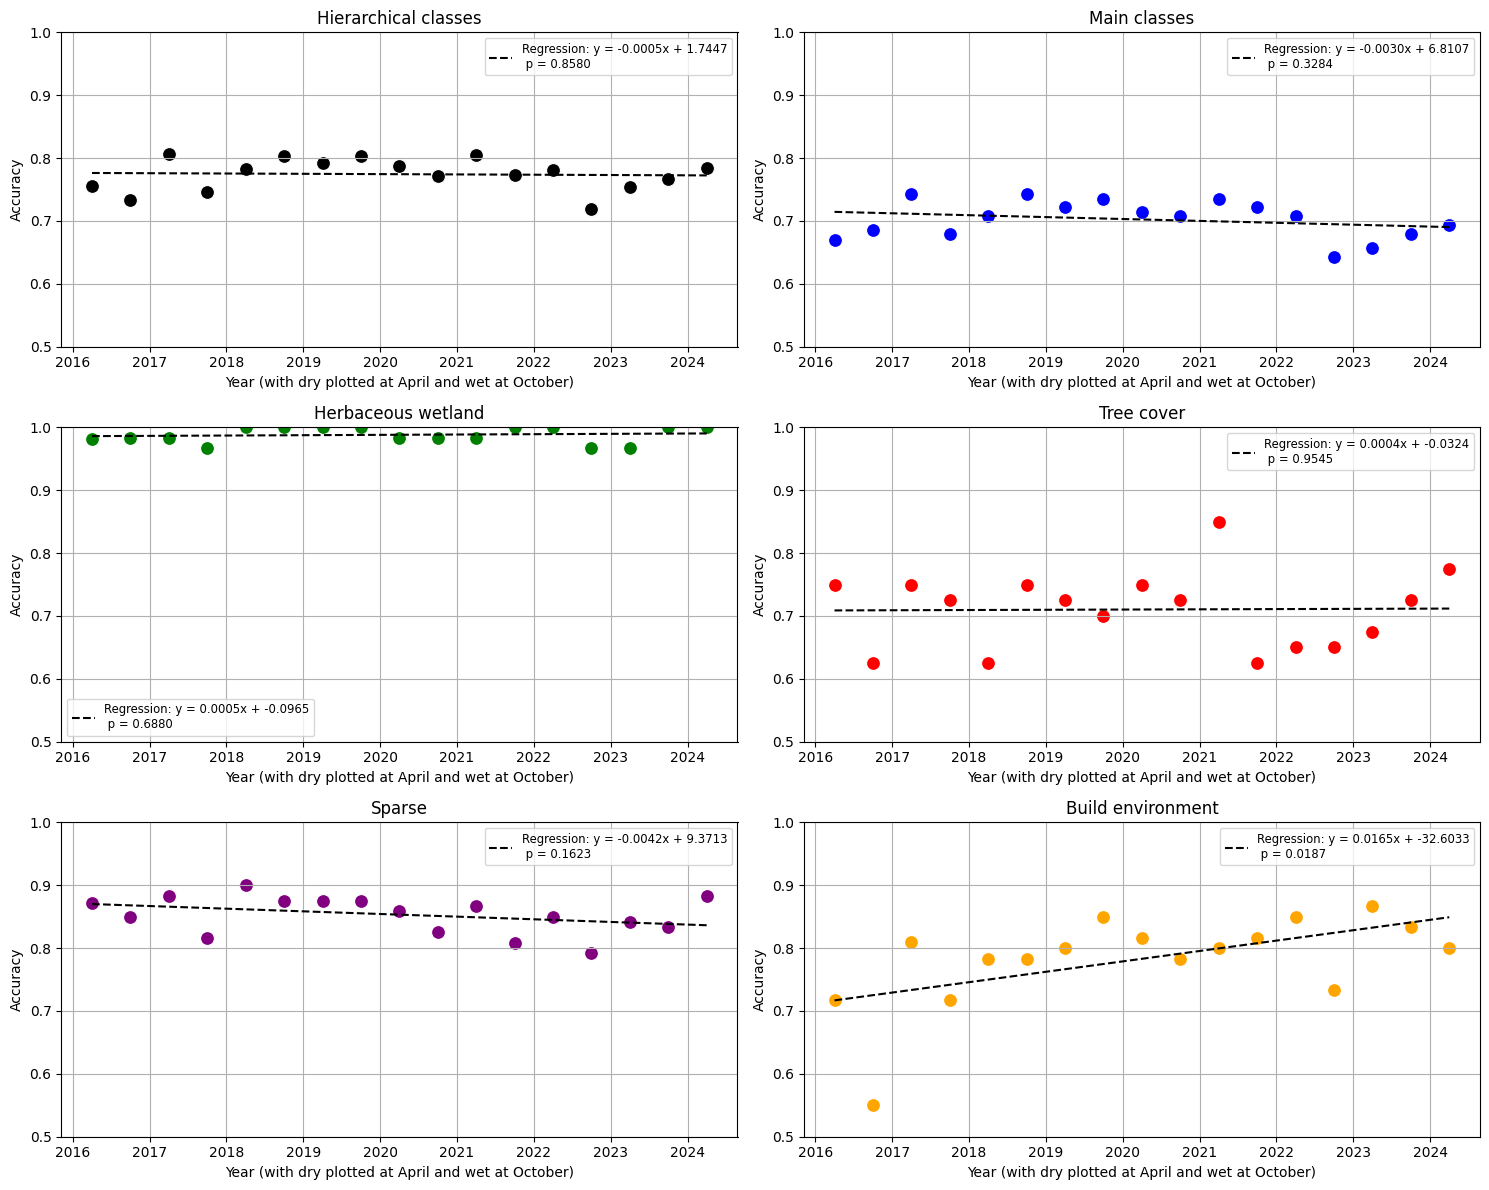

All problems combined exported as all_problems_accuracy.csv


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
import re

# Function to extract the year and type (wet/dry) from 'image_names' like '2024_dry'
def extract_year_and_type(name):
    match = re.match(r"(\d{4})_(\w+)", name)
    if match:
        year = int(match.group(1))
        type_ = match.group(2)
        # Treat 'dry' as April (month 4) and 'wet' as October (month 10)
        month = 4 if type_ == 'dry' else 10
        return year + (month - 1) / 12  # Convert year and month to a float
    return None

# Colors for each problem
color_map = {
    'hierarchical': 'black',
    'main': 'blue',
    'Herbaceous_wetland': 'green',
    'Tree_cover': 'red',
    'Sparse': 'purple',
    'Build_environment': 'orange'
}

# Prepare a single CSV file for all problems
all_data = pd.DataFrame({
    'Names': image_names,
})

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 columns
axs = axs.flatten()  # Flatten to 1D array to easily iterate

# Loop through each problem to create tables and regression lines
for idx, (problem, accuracies) in enumerate(accuracyOverTime.items()):
    prettyProblem = prettyProblemNames[idx]

    # Create a DataFrame for each problem
    df_problem = pd.DataFrame({
        'Names': image_names,
        'Accuracy': accuracies
    })

    # Merge data for single export later
    all_data[problem] = accuracies

    # Extract years and types ('wet'/'dry') from the names and convert to numeric format
    year_months = [extract_year_and_type(name) for name in image_names]
    year_months = np.array(year_months)

    # Ensure valid numeric data is available
    if None in year_months:
        raise ValueError("One or more 'image_names' do not contain a valid year or type.")

    # Create regression model for all points
    X = year_months.reshape(-1, 1)
    y = np.array(accuracies)

    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Calculate the slope, intercept, and p-value for the regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(year_months, accuracies)

    # Plot the points for both 'wet' and 'dry' treated as April and October
    sns.scatterplot(x=year_months, y=accuracies, ax=axs[idx], s=100, color=color_map[problem])

    # Plot the regression line
    axs[idx].plot(year_months, y_pred, linestyle='--', color='black', label=f'Regression: y = {slope:.4f}x + {intercept:.4f}\n p = {p_value:.4f}')

    # Set labels and title
    axs[idx].set_xlabel('Year (with dry plotted at April and wet at October)')
    axs[idx].set_ylabel('Accuracy')
    axs[idx].set_ylim(0.5, 1)  # Set y-axis range from 0.5 to 1
    axs[idx].set_title(f'{prettyProblem}')
    axs[idx].legend(fontsize='small')
    axs[idx].grid(True)

# Remove the last subplot if there are fewer problems than subplots (empty space)
for i in range(len(accuracyOverTime), len(axs)):
    fig.delaxes(axs[i])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the combined plot with 5 subplot
plt.show()

# Export the combined data to a single CSV file
all_data.to_csv('all_problems_accuracy.csv', index=False)
print('All problems combined exported as all_problems_accuracy.csv')


In [6]:
# Mean confusion matrixes
import numpy as np

np.set_printoptions(suppress=True)

# Hier moet je het mee doen: classConfMatrixes, subClassConfMatrixes
confMatrixes = {'main' : classConfMatrixes} | subClassConfMatrixes

# meanConfusionMatrixes = {problemName: None for problemName in confMatrixes.keys()}
lastConfusionMatrixes = {problemName: np.array(confMatrixes[problemName][-1].getInfo()) for problemName in confMatrixes.keys()}

# for problemName, confMatrixList in confMatrixes.items():
#     # Create empy confusion matrix for every problem
#     firstConfMatrix = np.array(confMatrixList[0].getInfo())
#     matrixDimension = firstConfMatrix.shape[0]
#     meanConfusionMatrixes[problemName] = np.zeros((matrixDimension, matrixDimension))    

#     for i, confMatrix in enumerate(confMatrixList):
#         # add all confusion matrixes together
#         npConfMatrix = np.array(confMatrix.getInfo())
#         meanConfusionMatrixes[problemName] += npConfMatrix
    
#     # Finally, divide by number of years, to obtain median confusion matrixes
#     meanConfusionMatrixes[problemName] /= len(years)
#     meanConfusionMatrixes[problemName] = meanConfusionMatrixes[problemName].round(2)


# meanConfusionMatrixes


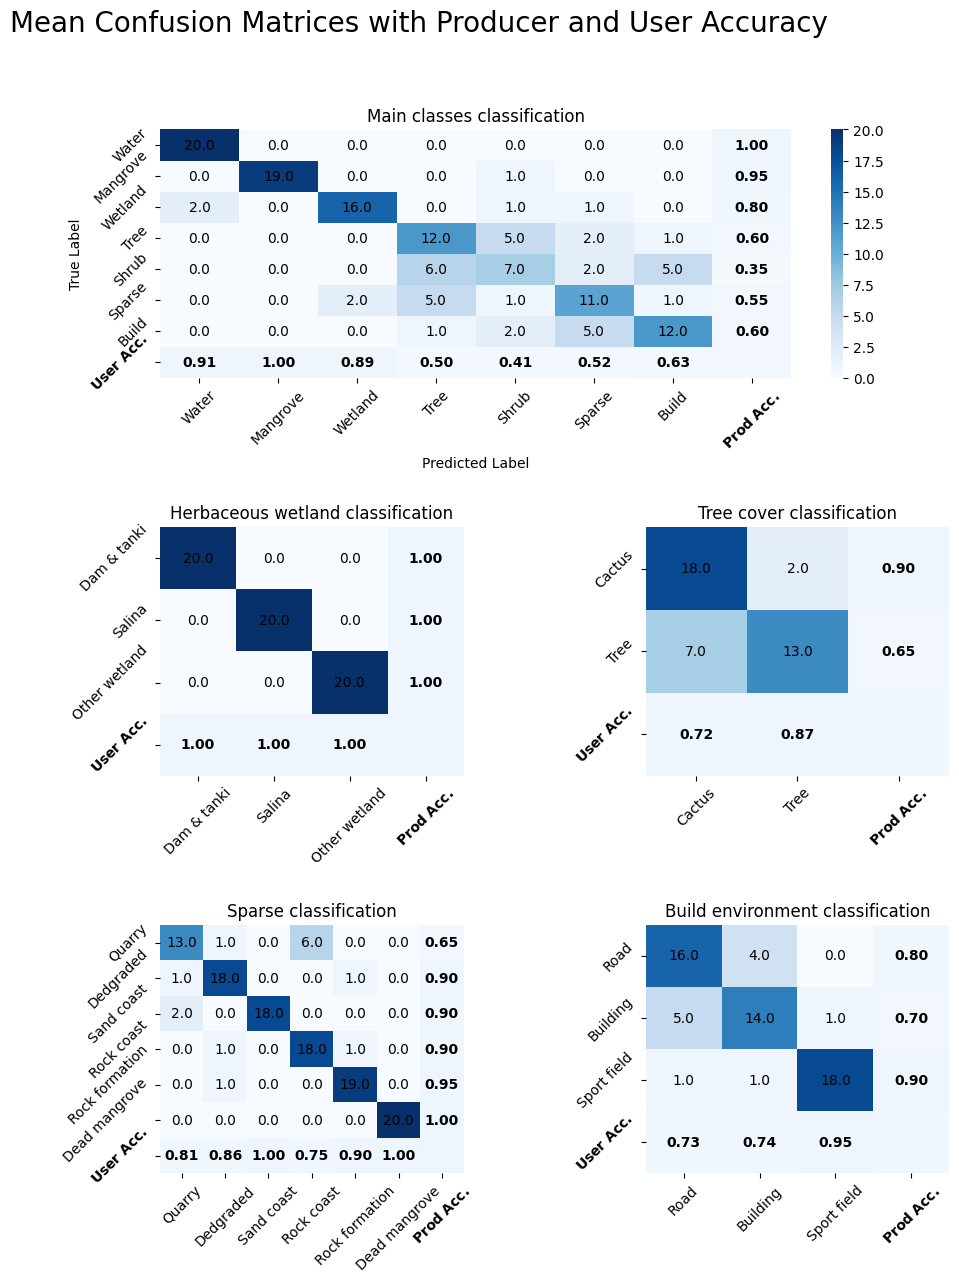

In [10]:
# show confusion matrixes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Create a grid layout with GridSpec, where the first plot spans two columns
fig = plt.figure(figsize=(15, 12))  # Increased figure size for better label spacing
gs = gridspec.GridSpec(3, 3, figure=fig)  # 3 rows, 3 columns layout

# Create the first plot spanning two columns
ax1 = fig.add_subplot(gs[0, :2])  # Span the first row across two columns

# Create the other four plots in a 2x2 grid
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

# Create a list of axes to make it easier to iterate
axs = [ax1, ax2, ax3, ax4, ax5]

# Function to calculate producer's accuracy (recall) and user's accuracy (precision)
def calculate_producers_and_users_accuracy(conf_matrix):
    # Producer's accuracy: True Positives / (True Positives + False Negatives)
    producers_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # User's accuracy: True Positives / (True Positives + False Positives)
    users_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)

    return producers_accuracy, users_accuracy

# Loop through each problem and plot the confusion matrix in the respective subplot
for i, problem in enumerate(problemNames):
    prettyProblemName = prettyProblemNames[i+1]
    prettySubClassNameList = prettySubClassNames[problem]
    confMatrix = lastConfusionMatrixes[problem]
    
    # Calculate producer's and user's accuracy
    producers_accuracy, users_accuracy = calculate_producers_and_users_accuracy(confMatrix)
    
    # Add the producer's and user's accuracy to the confusion matrix
    extended_conf_matrix = np.zeros((confMatrix.shape[0] + 1, confMatrix.shape[1] + 1))
    extended_conf_matrix[:-1, :-1] = confMatrix  # Original confusion matrix
    
    # Adding user's accuracy as the last column
    extended_conf_matrix[:-1, -1] = producers_accuracy
    
    # Adding producer's accuracy as the last row
    extended_conf_matrix[-1, :-1] = users_accuracy
    
    # The last row and column (bottom-right) can be the mean accuracy (overall accuracy)
    overall_accuracy = np.sum(np.diag(confMatrix)) / np.sum(confMatrix)
    extended_conf_matrix[-1, -1] = overall_accuracy
    
    # Extend the class labels to include 'User Acc.' and 'Prod Acc.'
    extended_class_labels = prettySubClassNameList + [r'$\mathbf{User\ Acc.}$'] # Make 'Prod Acc.' bold
    extended_tick_labels = prettySubClassNameList + [r'$\mathbf{Prod\ Acc.}$']  # Make 'User Acc.' bold
    
    if i == 0:
        # Plot the heatmap on the corresponding subplot
        sns.heatmap(extended_conf_matrix, annot=False, cmap='Blues', vmin=0, vmax=20,
                    xticklabels=extended_tick_labels,
                    yticklabels=extended_class_labels, ax=axs[i])
        
        # Set labels and title for the first subplot
        axs[i].set_xlabel('Predicted Label')
        axs[i].set_ylabel('True Label')

    else:
        # Plot the heatmap on the corresponding subplot without color bar
        sns.heatmap(extended_conf_matrix, annot=False, cmap='Blues', vmin=0, vmax=20,
                    xticklabels=extended_tick_labels,
                    yticklabels=extended_class_labels, ax=axs[i], cbar=False)
        
        # Remove x-axis label, y-axis label, and legend for all other subplots
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')

    axs[i].set_title(f'{prettyProblemName} classification')

    # Rotate x and y tick labels for better readability
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis tick labels
    axs[i].tick_params(axis='y', rotation=45)  # Rotate y-axis tick labels

    # Manually annotate the heatmap for better clarity
    for row in range(extended_conf_matrix.shape[0]):
        for col in range(extended_conf_matrix.shape[1]):
            value = extended_conf_matrix[row, col]
            if row == extended_conf_matrix.shape[0] - 1 and col == extended_conf_matrix.shape[1] - 1:
                pass
            elif row == extended_conf_matrix.shape[0] - 1 or col == extended_conf_matrix.shape[1] - 1:
                # Producer's and User's accuracy (last row or last column)
                axs[i].text(col + 0.5, row + 0.5, f'{value:.2f}',
                            ha='center', va='center', fontweight='bold', color='black')
            else:
                # Confusion matrix value (display as integer)
                axs[i].text(col + 0.5, row + 0.5, f'{value}',
                            ha='center', va='center', color='black')

    # Add border around the subplot
    for spine in axs[i].spines.values():
        spine.set_edgecolor('black')  # Set border color
        spine.set_linewidth(2)  # Set border thickness

# Remove the empty third column in the last row
fig.delaxes(fig.add_subplot(gs[2, 2]))

# Add a larger overall title for the entire figure and center it
plt.suptitle('Mean Confusion Matrices with Producer and User Accuracy', fontsize=20, x=0.0, y=1.02, ha='left')

# Adjust layout to add more padding around subplots
plt.subplots_adjust(left=0.10, right=0.95, top=0.92, bottom=0.05, hspace=0.6, wspace=0.6)

# Show the combined figure with all subplots
plt.show()


In [61]:
# Application: set permissions for each asset
import ee
ee.Initialize()

gen_path = 'projects/aruba-tdf/assets/'
folderEnds = ['1-images', '2-mainClasses', '3-subClasses/Herbaceous_wetland', '3-subClasses/Tree_cover', '3-subClasses/Sparse', '3-subClasses/Build_environment']

for folderEnd in folderEnds:
    folder_path = gen_path + folderEnd
    asset_list = ee.data.listAssets({'parent': folder_path})
    assets = [asset['id'] for asset in asset_list['assets']]

    for asset in assets:
        print(f'Setting {asset} to public')
        ee.data.setAssetAcl(asset, {"all_users_can_read": True})


Setting projects/aruba-tdf/assets/1-images/2016_dry to public
Setting projects/aruba-tdf/assets/1-images/2016_wet to public
Setting projects/aruba-tdf/assets/1-images/2017_dry to public
Setting projects/aruba-tdf/assets/1-images/2017_wet to public
Setting projects/aruba-tdf/assets/1-images/2018_dry to public
Setting projects/aruba-tdf/assets/1-images/2018_wet to public
Setting projects/aruba-tdf/assets/1-images/2019_dry to public
Setting projects/aruba-tdf/assets/1-images/2019_wet to public
Setting projects/aruba-tdf/assets/1-images/2020_dry to public
Setting projects/aruba-tdf/assets/1-images/2020_wet to public
Setting projects/aruba-tdf/assets/1-images/2021_dry to public
Setting projects/aruba-tdf/assets/1-images/2021_wet to public
Setting projects/aruba-tdf/assets/1-images/2022_dry to public
Setting projects/aruba-tdf/assets/1-images/2022_wet to public
Setting projects/aruba-tdf/assets/1-images/2023_dry to public
Setting projects/aruba-tdf/assets/1-images/2023_wet to public
Setting 